**Check GPU availability**

In [25]:
import tensorflow as tf

rtx3060 = tf.config.list_physical_devices('GPU')
for num in rtx3060:
    tf.config.experimental.set_memory_growth(num, True)

print(rtx3060)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Import libraries**

In [26]:
import matplotlib.image as img
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import pathlib

**Create folder (If it does not exist yet)**

In [27]:

# Create a new folder for training and testing segment based on data source suggestion

pfolder = "/home/makima/change-this-later/food-101/images"
ptext_train = "/home/makima/change-this-later/food-101/meta/train.txt" 
ptext_test = "/home/makima/change-this-later/food-101/meta/test.txt" 

data_dir = pathlib.Path(pfolder)
all_classes = len(list(data_dir.glob("*")))

"""Split the image into train and test"""
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print(data_dir,)
# ============= Run the fucntion ================================
prepare_data(ptext_train, data_dir, 'pic/trainer')
prepare_data(ptext_test, data_dir, 'pic/tester')
# The image will show at the working directory



Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying images into  croque_madam

**Choose the set of images to train**

In [28]:
def dataset_select(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

food_list = ['bibimbap','caesar_salad', 'cheesecake','chicken_curry','chicken_wings','chocolate_cake','club_sandwich','crab_cakes','creme_brulee','cup_cakes',\
             'donuts','dumplings','edamame','eggs_benedict','filet_mignon','fish_and_chips','foie_gras','french_fries','fried_rice','frozen_yogurt','garlic_bread',\
             'grilled_cheese_sandwich','grilled_salmon','gyoza','hamburger','hot_and_sour_soup','hot_dog','ice_cream','lasagna','lobster_bisque','macaroni_and_cheese',\
             'macarons','miso_soup','mussels','omelette','onion_rings','oysters','pad_thai','pancakes','panna_cotta','peking_duck','pho','pizza','ramen','risotto',\
             'steak','sashimi','scallops','spaghetti_bolognese','spaghetti_carbonara','sushi','takoyaki','tiramisu','waffles']

# In case some of the labels arrangement is wrong, sort it alphabetically
food_list = np.sort(food_list)

# Please check that in your working directory have the these files or not. If not, please run the above section 
src_test = "pic/tester"
dst_test = "pic/split/test54"
src_train = "pic/trainer"
dst_train = "pic/split/train54"

dataset_select(food_list, src_train, dst_train)
dataset_select(food_list, src_test, dst_test)

train_folder = pathlib.Path("pic/split/train54/")
test_folder = pathlib.Path("pic/split/test54/")

Copying images into bibimbap
Copying images into caesar_salad
Copying images into cheesecake
Copying images into chicken_curry
Copying images into chicken_wings
Copying images into chocolate_cake
Copying images into club_sandwich
Copying images into crab_cakes
Copying images into creme_brulee
Copying images into cup_cakes
Copying images into donuts
Copying images into dumplings
Copying images into edamame
Copying images into eggs_benedict
Copying images into filet_mignon
Copying images into fish_and_chips
Copying images into foie_gras
Copying images into french_fries
Copying images into fried_rice
Copying images into frozen_yogurt
Copying images into garlic_bread
Copying images into grilled_cheese_sandwich
Copying images into grilled_salmon
Copying images into gyoza
Copying images into hamburger
Copying images into hot_and_sour_soup
Copying images into hot_dog
Copying images into ice_cream
Copying images into lasagna
Copying images into lobster_bisque
Copying images into macaroni_and_c

**Parameters define**

In [29]:
# Food classes chosen
n_classes=54 
img_width, img_height = 299, 299
train_data_dir = 'pic/split/train54/'
validation_data_dir = 'pic/split/test54'
# 750 images for each class (training)
nb_train_samples = 40500 
# 250 images for each class (validation)
nb_validation_samples = 13500 #and this one
batch_size = 32

In [30]:
# Rescaling into 0 - 1.0 and perform some image augmentations
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Only rescaling into 0 - 1.0
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

# Split into training and validation section ("xxx images belong to 54 classes")
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

# Inception module as an input
inception = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

predictions = tf.keras.layers.Dense(n_classes,kernel_regularizer=tf.keras.regularizers.l2(0.005), activation='softmax')(x)

model = tf.keras.models.Model(inputs=inception.input, outputs=predictions)
#model.summary()

Found 40500 images belonging to 54 classes.
Found 13500 images belonging to 54 classes.


**Model training**

In [31]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# A function to prevent model from become overfit
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs = {}):
        if epoch >= 10 and logs.get("accuracy") is not None and logs.get("val_accuracy") >= 0.1:
            print("Model tends to be overfitting.Stop it.")
            self.model.stop_training = True
        elif logs.get('acccuracy') is not None and logs.get('accuracy') > 0.95:
            print("Model tends to be overfitting.Stop it.")
            self.model.stop_training = True
callback = myCallback()

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='test/best_model_54class.hdf5', verbose=1, save_best_only=True)

csv_logger = tf.keras.callbacks.CSVLogger('history_54class.log')

history_54class = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data = validation_generator,
                    validation_steps = nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[callback,csv_logger, checkpointer])
                    
model.save('model_trained_54class.hdf5')

Epoch 1/30
1265/1265 [==============================] - ETA: 0s - loss: 4.1445 - accuracy: 0.1056
Epoch 1: val_loss improved from inf to 3.58124, saving model to test/best_model_54class.hdf5
1265/1265 [==============================] - 531s 415ms/step - loss: 4.1445 - accuracy: 0.1056 - val_loss: 3.5812 - val_accuracy: 0.3305
Epoch 2/30
1265/1265 [==============================] - ETA: 0s - loss: 3.2540 - accuracy: 0.3432
Epoch 2: val_loss improved from 3.58124 to 2.46219, saving model to test/best_model_54class.hdf5
1265/1265 [==============================] - 521s 412ms/step - loss: 3.2540 - accuracy: 0.3432 - val_loss: 2.4622 - val_accuracy: 0.5542
Epoch 3/30
1265/1265 [==============================] - ETA: 0s - loss: 2.4980 - accuracy: 0.4927
Epoch 3: val_loss improved from 2.46219 to 1.79266, saving model to test/best_model_54class.hdf5
1265/1265 [==============================] - 513s 406ms/step - loss: 2.4980 - accuracy: 0.4927 - val_loss: 1.7927 - val_accuracy: 0.6755
Epoch 4/

**Plot model accuracy**

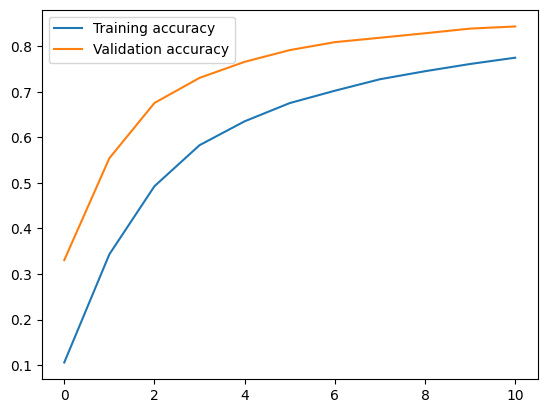

In [32]:
acc = history_54class.history["accuracy"]
val_acc = history_54class.history["val_accuracy"]

epochs = range(11)
plt.plot(epochs,acc,label="Training accuracy")
plt.plot(epochs,val_acc,label="Validation accuracy")
plt.legend()
plt.show()

**Plot model loss**

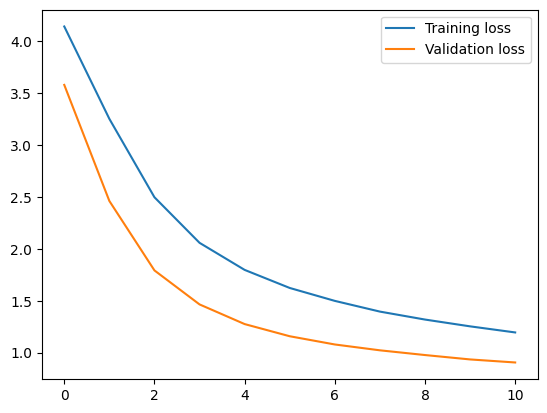

In [33]:
loss = history_54class.history["loss"]
val_loss = history_54class.history["val_loss"]

epochs = range(11)
plt.plot(epochs,loss,label="Training loss")
plt.plot(epochs,val_loss,label="Validation loss")
plt.legend()
plt.show()